# CPU vs. GPU for neural networks

**System Specifications**
- CPU/Host: AMD 7950X3D 16-core, 64 GiB RAM, WSL 2 Ubuntu 22.04.3 LTS
- GPU: RTX 4090, CUDA 12.3

In [ ]:
import gc
import time
import sys

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
# Defaults
print(f'Using default precision: {torch.get_default_dtype()}')
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_model_default = 128
n_layers_default = 128
batch_size_default = 1
iterations_default = 8

torch.manual_seed(1337)

Using default precision: torch.float32


In [ ]:
# Model Definition: A bunch of FeedForward layers with residual connections
class DumbBlock(nn.Module):

  def __init__(self, d_model):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(d_model, d_model, bias=False),
      nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x) + x # Residual connection

class DumbModel(nn.Module):

  def __init__(self, d_model, n_layers):
    super().__init__()
    self.blocks = nn.Sequential(*[DumbBlock(d_model) for _ in range(n_layers)])

  def forward(self, x):
    return self.blocks(x)

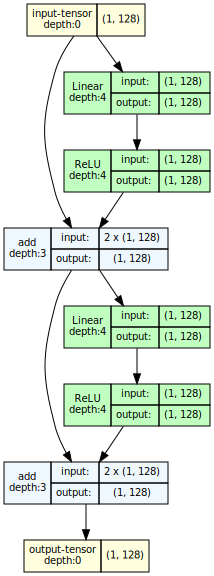

In [ ]:
# Visualize network: https://github.com/mert-kurttutan/torchview
from torchview import draw_graph
# device='meta' -> no memory is consumed for visualization
graph = draw_graph(
  DumbModel(d_model=d_model_default, n_layers=2), 
  input_size=(1, d_model_default), 
  depth=4,
  device='meta')
graph.resize_graph(scale=1.5) # > 1.0 makes it smaller?
graph.visual_graph

In [ ]:
# Test Harness
def run_tests(device, d_models=None, n_layers=None, batch_sizes=None, iterations=iterations_default):
  d_models = [] if d_models is None else d_models
  n_layers = [] if n_layers is None else n_layers
  batch_sizes = [] if batch_sizes is None else batch_sizes
  l = max(len(d_models), len(n_layers), len(batch_sizes))
  if l == 0:
    return []
  d_models += [d_model_default] * (l-len(d_models))
  n_layers += [n_layers_default] * (l-len(n_layers))
  batch_sizes += [batch_size_default] * (l-len(batch_sizes))

  params = zip(d_models, n_layers, batch_sizes)
  results = []
  for p in params:
    results.append((p, test_model(device, *p, iterations=iterations)))
  return results

@torch.no_grad() # Disable gradients since only doing forward pass
def test_model(device, 
               d_model=d_model_default, 
               n_layers=n_layers_default, 
               batch_size=batch_size_default, 
               iterations=iterations_default):
  # Create, move to device, set eval model since don't need to train
  model = DumbModel(d_model=d_model, n_layers=n_layers).to(device)
  model.eval()
  #model = torch.compile(model, mode="reduce-overhead")
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'Test: {device=}, {num_params=}, {d_model=}, {n_layers=}, {batch_size=}, {iterations=}')
  timings = []
  for _ in range(iterations):
    x = torch.randn(batch_size, d_model, requires_grad=False).to(device)
    fn = lambda: model(x)
    out, duration_ms = time_gpu(fn) if device == 'cuda' else time_cpu(fn)
  
    #print(f'{input[0][0].item()=}')
    #print(f'Input shape: {input.shape}')
    #print(f'Output shape: {out.shape}')
    #print(f'Output: {out[0][0].item()=}')
    #print(f'Time taken: {duration_ms:.2f} ms')
    timings.append(duration_ms)
  
  # Reclaim memory
  del model
  gc.collect()
  torch.cuda.empty_cache()
  
  # Simply taken the median of the trials as our "result".
  return torch.tensor(timings).median().item()

def time_gpu_old(fn):
  start = time.time()
  res = fn()
  torch.cuda.synchronize() # Needed for accurate CUDA timing.
  duration_ms = (time.time() - start) * 1000
  return res, duration_ms

def time_gpu(fn):
  # Based on: https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html#demonstrating-speedups  
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()
  res = fn()
  end.record()
  torch.cuda.synchronize() # Needed for accurate CUDA timing.
  return res, start.elapsed_time(end) # Time is in ms

def time_cpu(fn):
  # NOTE: torch.cpu.synchronize() is a noop:
  # https://pytorch.org/docs/stable/_modules/torch/cpu.html#synchronize
  start = time.time()
  res = fn()
  duration_ms = (time.time() - start) * 1000
  return res, duration_ms

In [ ]:
# For plotting results
def plot_results(title, cpu_results=None, gpu_results=None, log_x=True, log_y=False, labelsize=None):
  plt.figure(figsize=(8, 6))
  if cpu_results:
    plt.plot(*zip(*cpu_results), label='cpu', marker='o')
  if gpu_results:
    plt.plot(*zip(*gpu_results), label='gpu', marker='x')
  plt.xlabel(title + (' (log)' if log_x else ''))
  if labelsize is not None:
    plt.tick_params(axis='x', labelsize=labelsize)
  plt.ylabel('inference time (ms)' + (' (log)' if log_y else ''))
  plt.title(f'{title}: CPU and GPU')
  if log_x:
    plt.xscale('log')  # Using a logarithmic scale for x-axis to better visualize the data
  if log_y:
    plt.yscale('log')
  plt.legend()  # Adding a legend to distinguish the sequences
  plt.grid(True)  # Adding a grid for better readability

# Batch Size tests

In [ ]:
batch_sizes = [2**k for k in range(12)]

In [ ]:
cpu_batch_size_results = run_tests('cpu', batch_sizes=batch_sizes)
cpu_batch_size_results

Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=2, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=4, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=8, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=16, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=32, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=64, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=128, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=256, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=512, iterations=8
Test: device='cpu', num_params=2097152, d_model=128

[((128, 128, 1), 1.9664764404296875),
 ((128, 128, 2), 2.740621566772461),
 ((128, 128, 4), 2.1305084228515625),
 ((128, 128, 8), 2.8972625732421875),
 ((128, 128, 16), 2.764463424682617),
 ((128, 128, 32), 2.536773681640625),
 ((128, 128, 64), 3.345966339111328),
 ((128, 128, 128), 5.095005035400391),
 ((128, 128, 256), 7.009267807006836),
 ((128, 128, 512), 10.668754577636719),
 ((128, 128, 1024), 17.67444610595703),
 ((128, 128, 2048), 27.715206146240234)]

In [ ]:
cuda_batch_size_results = run_tests('cuda', batch_sizes=batch_sizes)
cuda_batch_size_results

Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=2, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=4, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=8, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=16, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=32, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=64, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=128, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=256, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=512, iterations=8
Test: device='cuda', num_params=2097152, 

[((128, 128, 1), 2.20579195022583),
 ((128, 128, 2), 2.1135358810424805),
 ((128, 128, 4), 2.1729280948638916),
 ((128, 128, 8), 2.0940799713134766),
 ((128, 128, 16), 2.2507519721984863),
 ((128, 128, 32), 2.4340479373931885),
 ((128, 128, 64), 2.4747838973999023),
 ((128, 128, 128), 2.1430718898773193),
 ((128, 128, 256), 2.1073920726776123),
 ((128, 128, 512), 2.1934080123901367),
 ((128, 128, 1024), 2.3797760009765625),
 ((128, 128, 2048), 2.1616640090942383)]

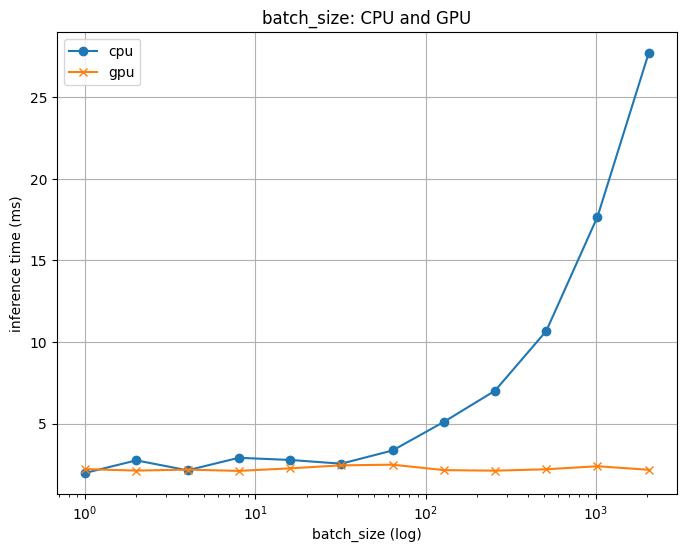

In [ ]:
plot_results('batch_size', 
             [(p[2], t) for p, t in cpu_batch_size_results], 
             [(p[2], t) for p, t in cuda_batch_size_results],
            )

# `d_model` tests

In [ ]:
d_models = [2**k for k in range(6, 13)] # Largest models taking 8G at FP32
cpu_d_model_results = run_tests('cpu', d_models=d_models)
cpu_d_model_results

Test: device='cpu', num_params=524288, d_model=64, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=8388608, d_model=256, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=33554432, d_model=512, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=134217728, d_model=1024, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=536870912, d_model=2048, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=2147483648, d_model=4096, n_layers=128, batch_size=1, iterations=8


[((64, 128, 1), 1.0273456573486328),
 ((128, 128, 1), 1.308441162109375),
 ((256, 128, 1), 3.2432079315185547),
 ((512, 128, 1), 8.677959442138672),
 ((1024, 128, 1), 20.72596549987793),
 ((2048, 128, 1), 71.60234069824219),
 ((4096, 128, 1), 259.4563903808594)]

In [ ]:
cuda_d_model_results = run_tests('cuda', d_models=d_models)
cuda_d_model_results

Test: device='cuda', num_params=524288, d_model=64, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=8388608, d_model=256, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=33554432, d_model=512, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=134217728, d_model=1024, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=536870912, d_model=2048, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=2147483648, d_model=4096, n_layers=128, batch_size=1, iterations=8


[((64, 128, 1), 5.138432025909424),
 ((128, 128, 1), 3.87174391746521),
 ((256, 128, 1), 3.9731199741363525),
 ((512, 128, 1), 9.81503963470459),
 ((1024, 128, 1), 2.181119918823242),
 ((2048, 128, 1), 3.1938560009002686),
 ((4096, 128, 1), 11.603679656982422)]

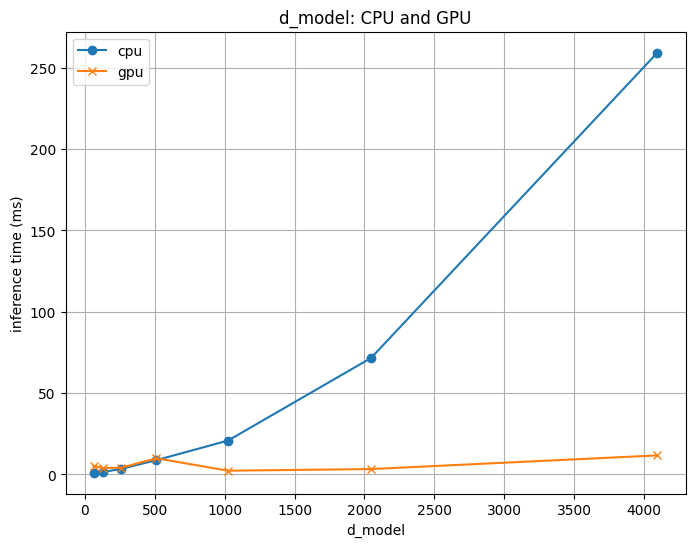

In [ ]:
plot_results('d_model', 
             [(p[0], t) for p, t in cpu_d_model_results], 
             [(p[0], t) for p, t in cuda_d_model_results],
             log_x=False
            )

# `n_layers` tests

In [ ]:
n_layers = [128*k for k in range(1, 31)]
cpu_n_layer_results = run_tests('cpu', n_layers=n_layers)
cpu_n_layer_results

Test: device='cpu', num_params=2097152, d_model=128, n_layers=128, batch_size=1, iterations=8
Test: device='cpu', num_params=4194304, d_model=128, n_layers=256, batch_size=1, iterations=8
Test: device='cpu', num_params=6291456, d_model=128, n_layers=384, batch_size=1, iterations=8
Test: device='cpu', num_params=8388608, d_model=128, n_layers=512, batch_size=1, iterations=8
Test: device='cpu', num_params=10485760, d_model=128, n_layers=640, batch_size=1, iterations=8
Test: device='cpu', num_params=12582912, d_model=128, n_layers=768, batch_size=1, iterations=8
Test: device='cpu', num_params=14680064, d_model=128, n_layers=896, batch_size=1, iterations=8
Test: device='cpu', num_params=16777216, d_model=128, n_layers=1024, batch_size=1, iterations=8
Test: device='cpu', num_params=18874368, d_model=128, n_layers=1152, batch_size=1, iterations=8
Test: device='cpu', num_params=20971520, d_model=128, n_layers=1280, batch_size=1, iterations=8
Test: device='cpu', num_params=23068672, d_model=12

[((128, 128, 1), 1.1947154998779297),
 ((128, 256, 1), 2.569913864135742),
 ((128, 384, 1), 5.827903747558594),
 ((128, 512, 1), 7.930755615234375),
 ((128, 640, 1), 9.775638580322266),
 ((128, 768, 1), 11.796236038208008),
 ((128, 896, 1), 14.448404312133789),
 ((128, 1024, 1), 17.14038848876953),
 ((128, 1152, 1), 17.837047576904297),
 ((128, 1280, 1), 19.883394241333008),
 ((128, 1408, 1), 22.61638641357422),
 ((128, 1536, 1), 24.13654327392578),
 ((128, 1664, 1), 26.167631149291992),
 ((128, 1792, 1), 27.997732162475586),
 ((128, 1920, 1), 30.0445556640625),
 ((128, 2048, 1), 31.66508674621582),
 ((128, 2176, 1), 36.531211853027344),
 ((128, 2304, 1), 37.75358200073242),
 ((128, 2432, 1), 40.39263916015625),
 ((128, 2560, 1), 40.8885498046875),
 ((128, 2688, 1), 42.360782623291016),
 ((128, 2816, 1), 43.692588806152344),
 ((128, 2944, 1), 46.01097106933594),
 ((128, 3072, 1), 48.29430389404297),
 ((128, 3200, 1), 53.447723388671875),
 ((128, 3328, 1), 52.81543731689453),
 ((128, 34

In [ ]:
cuda_n_layer_results = run_tests('cuda', n_layers=n_layers)
cuda_n_layer_results

Test: device='cuda', num_params=2097152, d_model=128, n_layers=128, batch_size=1, iterations=8
Test: device='cuda', num_params=4194304, d_model=128, n_layers=256, batch_size=1, iterations=8
Test: device='cuda', num_params=6291456, d_model=128, n_layers=384, batch_size=1, iterations=8
Test: device='cuda', num_params=8388608, d_model=128, n_layers=512, batch_size=1, iterations=8
Test: device='cuda', num_params=10485760, d_model=128, n_layers=640, batch_size=1, iterations=8
Test: device='cuda', num_params=12582912, d_model=128, n_layers=768, batch_size=1, iterations=8
Test: device='cuda', num_params=14680064, d_model=128, n_layers=896, batch_size=1, iterations=8
Test: device='cuda', num_params=16777216, d_model=128, n_layers=1024, batch_size=1, iterations=8
Test: device='cuda', num_params=18874368, d_model=128, n_layers=1152, batch_size=1, iterations=8
Test: device='cuda', num_params=20971520, d_model=128, n_layers=1280, batch_size=1, iterations=8
Test: device='cuda', num_params=23068672,

[((128, 128, 1), 2.4494080543518066),
 ((128, 256, 1), 5.06163215637207),
 ((128, 384, 1), 7.590879917144775),
 ((128, 512, 1), 13.605888366699219),
 ((128, 640, 1), 14.659584045410156),
 ((128, 768, 1), 13.579263687133789),
 ((128, 896, 1), 17.448959350585938),
 ((128, 1024, 1), 18.24460792541504),
 ((128, 1152, 1), 23.946239471435547),
 ((128, 1280, 1), 23.45267105102539),
 ((128, 1408, 1), 28.328960418701172),
 ((128, 1536, 1), 29.010944366455078),
 ((128, 1664, 1), 33.071903228759766),
 ((128, 1792, 1), 34.79347229003906),
 ((128, 1920, 1), 40.77772903442383),
 ((128, 2048, 1), 44.69657516479492),
 ((128, 2176, 1), 46.77222442626953),
 ((128, 2304, 1), 48.52937698364258),
 ((128, 2432, 1), 48.26121520996094),
 ((128, 2560, 1), 55.66156768798828),
 ((128, 2688, 1), 58.80012893676758),
 ((128, 2816, 1), 56.55039978027344),
 ((128, 2944, 1), 64.96358489990234),
 ((128, 3072, 1), 61.690879821777344),
 ((128, 3200, 1), 69.3780517578125),
 ((128, 3328, 1), 65.93033599853516),
 ((128, 345

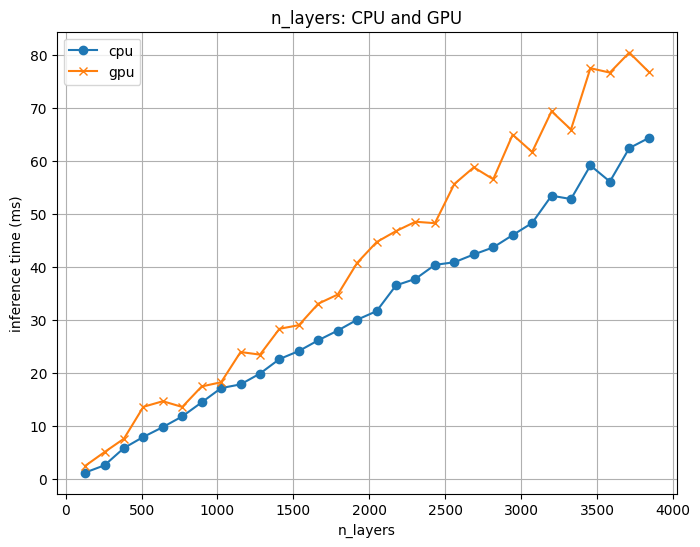

In [ ]:
plot_results('n_layers', 
             [(p[1], t) for p, t in cpu_n_layer_results], 
             [(p[1], t) for p, t in cuda_n_layer_results],
             log_x=False)

# Fixed parameter count, trading off between `d_model` and `n_layers`

In [ ]:
max_n_params = 2**31 # Fix number of parameters at ~2B
d_models = [2**k for k in range(7, 13)]
n_layers = [max_n_params // d**2 for d in d_models] # NOTE: A ridiculous number of layers for smaller `d_model`
cpu_fixed_n_param_results = run_tests('cpu', d_models=d_models, n_layers=n_layers)
cpu_fixed_n_param_results

Test: device='cpu', num_params=2147483648, d_model=128, n_layers=131072, batch_size=1, iterations=8
Test: device='cpu', num_params=2147483648, d_model=256, n_layers=32768, batch_size=1, iterations=8
Test: device='cpu', num_params=2147483648, d_model=512, n_layers=8192, batch_size=1, iterations=8
Test: device='cpu', num_params=2147483648, d_model=1024, n_layers=2048, batch_size=1, iterations=8
Test: device='cpu', num_params=2147483648, d_model=2048, n_layers=512, batch_size=1, iterations=8
Test: device='cpu', num_params=2147483648, d_model=4096, n_layers=128, batch_size=1, iterations=8


[((128, 131072, 1), 2051.66357421875),
 ((256, 32768, 1), 929.3504028320312),
 ((512, 8192, 1), 556.9703369140625),
 ((1024, 2048, 1), 364.705322265625),
 ((2048, 512, 1), 313.9002380371094),
 ((4096, 128, 1), 288.2447204589844)]

In [ ]:
cuda_fixed_n_param_results = run_tests('cuda', d_models=d_models, n_layers=n_layers)
cuda_fixed_n_param_results

Test: device='cuda', num_params=2147483648, d_model=128, n_layers=131072, batch_size=1, iterations=8
Test: device='cuda', num_params=2147483648, d_model=256, n_layers=32768, batch_size=1, iterations=8
Test: device='cuda', num_params=2147483648, d_model=512, n_layers=8192, batch_size=1, iterations=8
Test: device='cuda', num_params=2147483648, d_model=1024, n_layers=2048, batch_size=1, iterations=8
Test: device='cuda', num_params=2147483648, d_model=2048, n_layers=512, batch_size=1, iterations=8
Test: device='cuda', num_params=2147483648, d_model=4096, n_layers=128, batch_size=1, iterations=8


[((128, 131072, 1), 2785.88818359375),
 ((256, 32768, 1), 733.1295166015625),
 ((512, 8192, 1), 187.72787475585938),
 ((1024, 2048, 1), 41.631744384765625),
 ((2048, 512, 1), 13.029984474182129),
 ((4096, 128, 1), 9.997952461242676)]

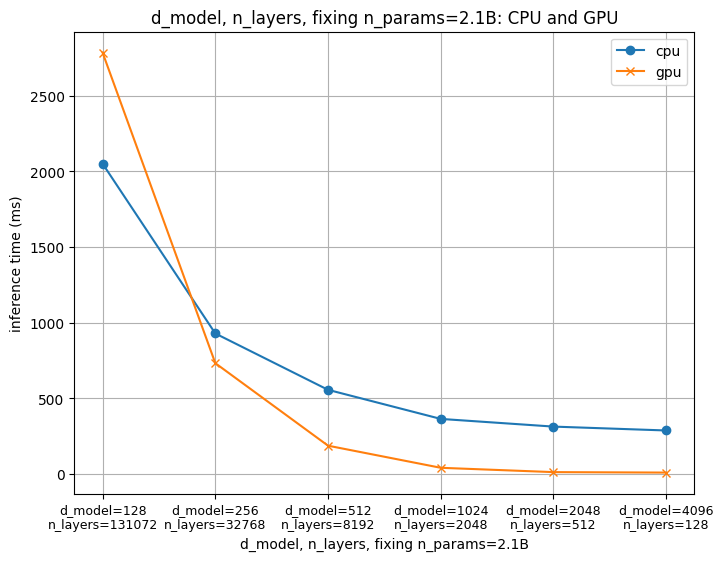

In [ ]:
plot_results(f'd_model, n_layers, fixing n_params={(max_n_params / 10**9):.1f}B',
             [(f'd_model={p[0]}\nn_layers={p[1]}', t) for p, t in cpu_fixed_n_param_results], 
             [(f'd_model={p[0]}\nn_layers={p[1]}', t) for p, t in cuda_fixed_n_param_results],
             log_x=False,
             labelsize=9)